C:\Users\Jamshid\AppData\Local\Temp\ipykernel_9368\410869984.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_cycle = plt.cm.get_cmap('tab10')  # Use a color map with different colors


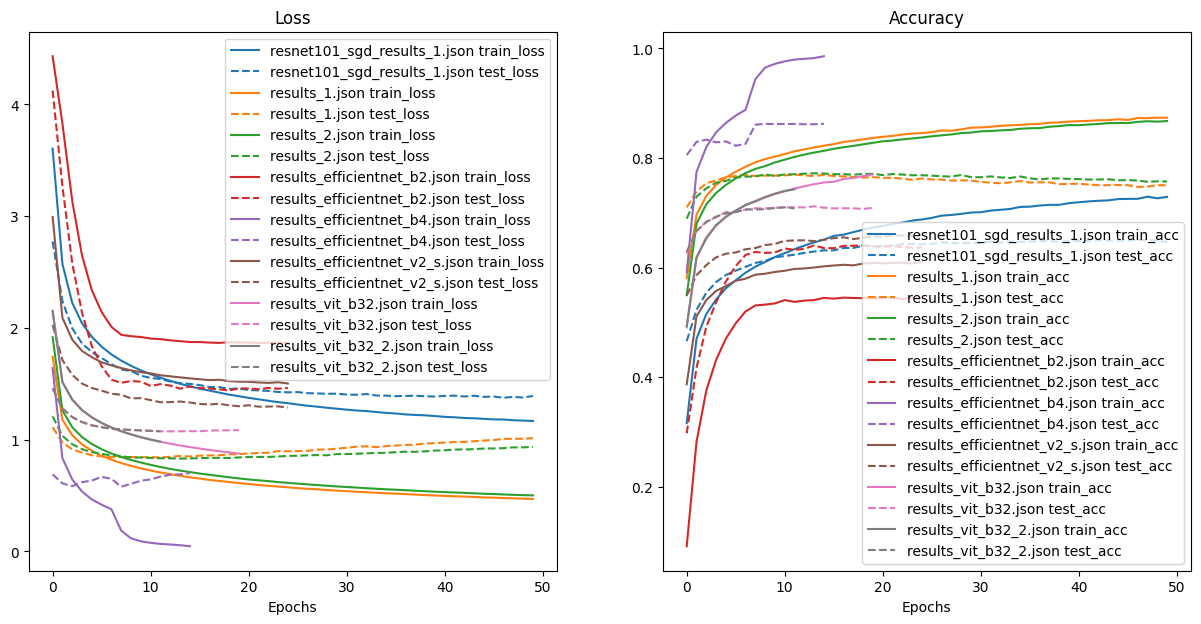

In [2]:
import os
import json
import matplotlib.pyplot as plt
from helper_functions import plot_loss_curves  

def load_results_from_directory(directory_path):
    """Load results from all JSON files in the specified directory."""
    results_dict = {}
    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):  
            filepath = os.path.join(directory_path, filename)
            with open(filepath, 'r') as file:
                results = json.load(file)
                results_dict[filename] = results
    return results_dict

def plot_all_model_curves(directory_path):
    """Plots loss and accuracy curves for all models in the directory."""
    results_dict = load_results_from_directory(directory_path)

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.xlabel("Epochs")

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.xlabel("Epochs")

    color_cycle = plt.cm.get_cmap('tab10')  # Use a color map with different colors
    color_index = 0

    for model_name, results in results_dict.items():
        epochs = range(len(results["train_loss"]))
        
        # Use the same color for loss and accuracy for each model
        color = color_cycle(color_index)
        color_index = (color_index + 1) % 10  # Loop through color palette

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, results["train_loss"], label=f"{model_name} train_loss", color=color)
        plt.plot(epochs, results["test_loss"], label=f"{model_name} test_loss", linestyle='--', color=color)

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, results["train_acc"], label=f"{model_name} train_acc", color=color)
        plt.plot(epochs, results["test_acc"], label=f"{model_name} test_acc", linestyle='--', color=color)

    plt.subplot(1, 2, 1)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.legend()

    plt.show()

# Example usage:
directory_path = "results"
plot_all_model_curves(directory_path)


In [3]:
import os

models = os.listdir("models_food101")
models

['efficientnet_b0_cifar10.pth',
 'pretrained_efficientnet_b2_model.pth',
 'pretrained_efficientnet_b4_model.pth',
 'pretrained_efficientnet_v2_s_model.pth',
 'pretrained_resnet_101_model.pth',
 'pretrained_vit_b32_model.pth',
 'pretrained_vit_b32_model_2.pth',
 'pretrained_vit_model.pth',
 'pretrained_vit_model_2.pth',
 'resnet_cifar100.pth']

In [4]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
models_dict = {}
for i in range(len(models)):
    models_dict[models[i]] = Path("models_food101" + '/' +  models[i]).stat().st_size // (1024*1024)

for k, v in models_dict.items():
    print(f"{k} : {v} MB")

efficientnet_b0_cifar10.pth : 15 MB
pretrained_efficientnet_b2_model.pth : 30 MB
pretrained_efficientnet_b4_model.pth : 68 MB
pretrained_efficientnet_v2_s_model.pth : 78 MB
pretrained_resnet_101_model.pth : 163 MB
pretrained_vit_b32_model.pth : 333 MB
pretrained_vit_b32_model_2.pth : 333 MB
pretrained_vit_model.pth : 327 MB
pretrained_vit_model_2.pth : 327 MB
resnet_cifar100.pth : 81 MB


In [5]:
import pathlib
import torch
import torchvision

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                  model: torch.nn.Module,
                  transform: torchvision.transforms,
                  class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    # 2. Create an empty list to store prediction dictionaries
    pred_list = []
    # 3. loop through target paths
    for path in tqdm(paths):
        # 4. Create an empty list to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict['image_path'] = path
        class_name = path.parent.stem
        pred_dict['class_name'] = class_name

        # 6. Start the prediction timer()
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on the eval() mode
        model.to(device)
        model.eval()

        # 10 Get prediction probability, prediction label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            # 11. Mkae sure things in the dict are on CPU ( required for instpecting predictions later on)
            pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 3)
            pred_dict['red_class'] = pred_class

            # 12. End the timer to calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class
        # 14. Add the dict to the list of preds
        pred_list.append(pred_dict)

    return pred_list

In [6]:
import torch
import torchvision
from torch import nn

# Initialize EfficientNet-B4 model
model = torchvision.models.efficientnet_b4(pretrained=False)

# Modify the classifier head to match 101 classes (for Food101)
model.classifier[1] = nn.Linear(in_features=1792, out_features=101)

# Use DataParallel to match the saved state dict
model = torch.nn.DataParallel(model)

# Load the saved weights
model.load_state_dict(torch.load("models_food101/pretrained_efficientnet_b4_model.pth"))

# Move model to the device (GPU or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Set the model to evaluation mode for inference
model.eval()

print(model)


C:\Users\Jamshid\Desktop\pytorch\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jamshid\Desktop\pytorch\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DataParallel(
  (module): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale

In [7]:
from torchvision import transforms
from going_modular import data_setup

train_dir = "data/test"
test_dir = "data/test"

pretrained_efficientnetb4_weights = torchvision.models.EfficientNet_B4_Weights.DEFAULT
efficientnetb4_transforms = transforms.Compose([
    transforms.Resize((380, 380)),  # Increase resolution to 380x380
    pretrained_efficientnetb4_weights.transforms(),  # Pre-trained EfficientNet-B4 normalization
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=efficientnetb4_transforms,
                                                                              batch_size=256)
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [8]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

effnetb4_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                         model=model,
                                         transform=efficientnetb4_transforms,
                                         class_names=class_names,
                                         device='cuda')

[INFO] Finding all filepaths ending with '.jpg' in directory: data/test


  0%|          | 0/20200 [00:00<?, ?it/s]

In [9]:
effnetb4_test_pred_dicts

[{'image_path': WindowsPath('data/test/apple_pie/1011328.jpg'),
  'class_name': 'apple_pie',
  'pred_prob': 0.976,
  'red_class': 'gyoza',
  'time_for_pred': 0.3989,
  'correct': False},
 {'image_path': WindowsPath('data/test/apple_pie/101251.jpg'),
  'class_name': 'apple_pie',
  'pred_prob': 1.0,
  'red_class': 'apple_pie',
  'time_for_pred': 0.031,
  'correct': True},
 {'image_path': WindowsPath('data/test/apple_pie/1034399.jpg'),
  'class_name': 'apple_pie',
  'pred_prob': 0.995,
  'red_class': 'apple_pie',
  'time_for_pred': 0.034,
  'correct': True},
 {'image_path': WindowsPath('data/test/apple_pie/103801.jpg'),
  'class_name': 'apple_pie',
  'pred_prob': 1.0,
  'red_class': 'apple_pie',
  'time_for_pred': 0.034,
  'correct': True},
 {'image_path': WindowsPath('data/test/apple_pie/1047447.jpg'),
  'class_name': 'apple_pie',
  'pred_prob': 0.993,
  'red_class': 'apple_pie',
  'time_for_pred': 0.0299,
  'correct': True},
 {'image_path': WindowsPath('data/test/apple_pie/1068632.jpg')

In [10]:
len(effnetb4_test_pred_dicts)

20200

In [11]:
effnetb4_test_pred_dicts[0]

{'image_path': WindowsPath('data/test/apple_pie/1011328.jpg'),
 'class_name': 'apple_pie',
 'pred_prob': 0.976,
 'red_class': 'gyoza',
 'time_for_pred': 0.3989,
 'correct': False}

In [12]:
wrong_preds = 0
for i in range(len(effnetb4_test_pred_dicts)):
    if effnetb4_test_pred_dicts[i]['correct'] == False:
        wrong_preds += 1

In [13]:
(len(effnetb4_test_pred_dicts) / wrong_preds) / 10

0.7313540912382333

In [14]:
effnetb4_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/test/apple_pie/1011328.jpg'),
  'class_name': 'apple_pie',
  'pred_prob': 0.976,
  'red_class': 'gyoza',
  'time_for_pred': 0.3989,
  'correct': False},
 {'image_path': WindowsPath('data/test/apple_pie/101251.jpg'),
  'class_name': 'apple_pie',
  'pred_prob': 1.0,
  'red_class': 'apple_pie',
  'time_for_pred': 0.031,
  'correct': True}]

In [15]:
import pandas as pd
effnetb4_test_pred_df = pd.DataFrame(effnetb4_test_pred_dicts)
effnetb4_test_pred_df.head()

,image_path,class_name,pred_prob,red_class,time_for_pred,correct
0,data\test\apple_pie\1011328.jpg,apple_pie,0.976,gyoza,0.3989,False
1,data\test\apple_pie\101251.jpg,apple_pie,1.000,apple_pie,0.0310,True
2,data\test\apple_pie\1034399.jpg,apple_pie,0.995,apple_pie,0.0340,True
3,data\test\apple_pie\103801.jpg,apple_pie,1.000,apple_pie,0.0340,True
4,data\test\apple_pie\1047447.jpg,apple_pie,0.993,apple_pie,0.0299,True


In [16]:
effnetb4_test_pred_df.correct.value_counts()

correct
True     17438
False     2762
Name: count, dtype: int64

In [17]:
# Find average time period prediction
effnetb4_average_time_per_pred = round(effnetb4_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB4 average time per prediction:{effnetb4_average_time_per_pred} seconds.")

EffNetB4 average time per prediction:0.0267 seconds.


In [18]:
print(f"{round(2199 / 2525, 3) * 100}%")

87.1%


# Prediction test run 2 | with 200 test images for each class
# Total : 20,200 test images for 101 classes

In [19]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

effnetb4_test_pred_dicts_2 = pred_and_store(paths=test_data_paths,
                                         model=model,
                                         transform=efficientnetb4_transforms,
                                         class_names=class_names,
                                         device='cuda')

[INFO] Finding all filepaths ending with '.jpg' in directory: data/test


  0%|          | 0/20200 [00:00<?, ?it/s]

In [20]:
effnetb4_test_pred_dicts_2[:2]

[{'image_path': WindowsPath('data/test/apple_pie/1011328.jpg'),
  'class_name': 'apple_pie',
  'pred_prob': 0.976,
  'red_class': 'gyoza',
  'time_for_pred': 0.0295,
  'correct': False},
 {'image_path': WindowsPath('data/test/apple_pie/101251.jpg'),
  'class_name': 'apple_pie',
  'pred_prob': 1.0,
  'red_class': 'apple_pie',
  'time_for_pred': 0.0284,
  'correct': True}]

In [21]:
import pandas as pd
effnetb4_test_pred_df_2= pd.DataFrame(effnetb4_test_pred_dicts_2)
effnetb4_test_pred_df_2.head()

,image_path,class_name,pred_prob,red_class,time_for_pred,correct
0,data\test\apple_pie\1011328.jpg,apple_pie,0.976,gyoza,0.0295,False
1,data\test\apple_pie\101251.jpg,apple_pie,1.000,apple_pie,0.0284,True
2,data\test\apple_pie\1034399.jpg,apple_pie,0.995,apple_pie,0.0282,True
3,data\test\apple_pie\103801.jpg,apple_pie,1.000,apple_pie,0.0270,True
4,data\test\apple_pie\1047447.jpg,apple_pie,0.993,apple_pie,0.0331,True


In [22]:
len(effnetb4_test_pred_dicts_2)

20200

In [23]:
effnetb4_test_pred_df_2.correct.value_counts()

correct
True     17438
False     2762
Name: count, dtype: int64

In [24]:
print(f"{round(17438 / len(effnetb4_test_pred_dicts_2), 3) * 100}%")

86.3%


In [25]:
# Find average time period prediction
effnetb4_average_time_per_pred_2 = round(effnetb4_test_pred_df_2.time_for_pred.mean(), 4)
print(f"EffNetB4 average time per prediction:{effnetb4_average_time_per_pred_2} seconds.")

EffNetB4 average time per prediction:0.0265 seconds.


In [26]:
effnet_b4_results = {
    "train_loss": [
        1.64002931762386,
        0.8354565678416072,
        0.6445213260280119,
        0.5361178366316331,
        0.465178761077491,
        0.4181656831422368,
        0.37720189686562566,
        0.185924747606387,
        0.11708441992114121,
        0.0907826023050458,
        0.07709137019323739,
        0.06755708877274112,
        0.062242068325144215,
        0.055947171694070506,
        0.046835999435594154
    ],
    "train_acc": [
        0.5910619858989424,
        0.7745668010061693,
        0.820092744748825,
        0.8470599845769683,
        0.8641000247870153,
        0.8774845540173325,
        0.8880362487147474,
        0.9439764110237955,
        0.9651545057285547,
        0.9719508528569331,
        0.9765064997062278,
        0.9796152045387779,
        0.9810536547076968,
        0.982475924463866,
        0.9858383519388954
    ],
    "test_loss": [
        0.6893176714880298,
        0.6091981571581628,
        0.583870479931133,
        0.6200098804753236,
        0.6343839331106707,
        0.6671971629063288,
        0.6501466177328669,
        0.579550165871177,
        0.6048787957941643,
        0.6330661965590535,
        0.6449009741496559,
        0.6698759831864425,
        0.6869810336466992,
        0.6894769415710912,
        0.7016165668163636
    ],
    "test_acc": [
        0.8053382981045019,
        0.8295089202207258,
        0.8335564362763437,
        0.8286471972814566,
        0.8303579779274223,
        0.8224485401858087,
        0.8257463718979924,
        0.8608237077565782,
        0.8623980935902232,
        0.8619742954233696,
        0.86223149706946,
        0.8621652481606186,
        0.8616980959284201,
        0.8615962869435091,
        0.8624414476555681
    ],
    "training_time": "1:12:16.003597",
    "batch_size": 256,
    "epochs": 15
}

In [27]:
effnetb4_stats = {"test_loss": round(effnet_b4_results["test_loss"][-1], 3),
             "test_acc": round(effnet_b4_results["test_acc"][-1], 3)*100,
             "model_size (MB)": 30}

In [28]:
effnetb4_stats["time_per_pred_gpu"] = round(effnetb4_average_time_per_pred,3)
effnetb4_stats

{'test_loss': 0.702,
 'test_acc': 86.2,
 'model_size (MB)': 30,
 'time_per_pred_gpu': 0.027}

# Visualizing the speed vs. performance tradeoff

In [29]:
# ...........

In [30]:
import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 4.44.0


# It's time to see the food vision model in the wild

In [31]:
effnetb4 = model

In [32]:
efficientnetb4_transforms

Compose(
    Resize(size=(380, 380), interpolation=bilinear, max_size=None, antialias=True)
    ImageClassification(
    crop_size=[380]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [33]:
len(class_names)

101

In [34]:
test_data_paths[:5]

[WindowsPath('data/test/apple_pie/1011328.jpg'),
 WindowsPath('data/test/apple_pie/101251.jpg'),
 WindowsPath('data/test/apple_pie/1034399.jpg'),
 WindowsPath('data/test/apple_pie/103801.jpg'),
 WindowsPath('data/test/apple_pie/1047447.jpg')]

In [35]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken."""
    start_time = timer()
    img = efficientnetb4_transforms(img).unsqueeze(0)

    effnetb4.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb4(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 3)

    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [36]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_label_and_prob, pred_time = predict(img=image)

print(f"Prediction label and probability dictionary: \n{pred_label_and_prob}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image path: data\test\lasagna\134578.jpg

Prediction label and probability dictionary: 
{'apple_pie': 2.1331786337341896e-10, 'baby_back_ribs': 5.7052261581702624e-08, 'baklava': 1.6957161369512974e-11, 'beef_carpaccio': 0.00022745240130461752, 'beef_tartare': 4.581664470038049e-08, 'beet_salad': 6.368261438183254e-07, 'beignets': 1.8848572480578696e-08, 'bibimbap': 1.4920026325526692e-09, 'bread_pudding': 1.1009796407890349e-09, 'breakfast_burrito': 1.752509206198738e-06, 'bruschetta': 1.6695900058039115e-06, 'caesar_salad': 7.057938944399211e-08, 'cannoli': 1.1251062304040715e-09, 'caprese_salad': 9.053856047103181e-06, 'carrot_cake': 2.1102171399167702e-10, 'ceviche': 8.408494522882393e-07, 'cheese_plate': 6.184226908345636e-09, 'cheesecake': 1.5328938118841506e-10, 'chicken_curry': 0.9945980310440063, 'chicken_quesadilla': 1.1911181445611874e-06, 'chicken_wings': 2.6686143428378273e-07, 'chocolate_cake': 1.065203264136172e-12, 'chocolate_mousse': 9.015548863011

In [41]:
round(pred_label_and_prob["caprese_salad"] * 100, 3)

0.001

In [38]:
# Create a list of example inputs to our Gradio demo
examples_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=10)]
len(examples_list)

10

In [43]:
vit_b16_stats = {'test_loss': 1.014,
                 'test_acc': 75.0,
                 'model_size (MB)': 327, 'time_per_pred_gpu': 0.0209}
effnetb4_stats

{'test_loss': 0.702,
 'test_acc': 86.2,
 'model_size (MB)': 30,
 'time_per_pred_gpu': 0.027}

In [44]:
df = pd.DataFrame([effnetb4_stats, vit_b16_stats])
df["model"] = ["EffNetB4", "ViT"]

df

,test_loss,test_acc,model_size (MB),time_per_pred_gpu,model
0,0.702,86.2,30,0.0270,EffNetB4
1,1.014,75.0,327,0.0209,ViT


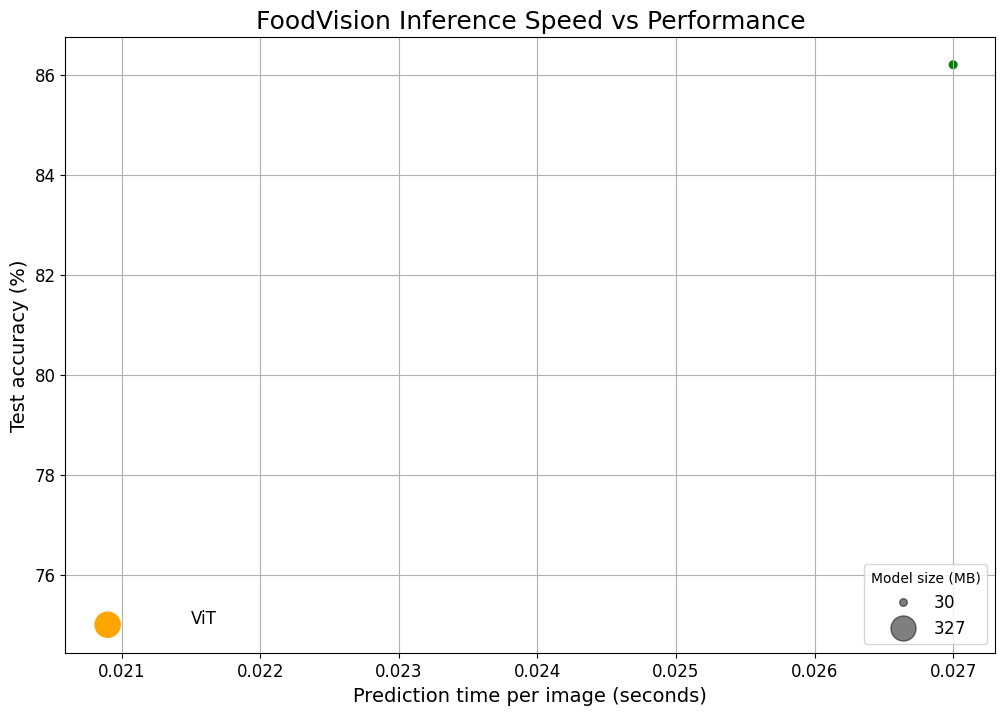

In [53]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_gpu", 
                     y="test_acc", 
                     c=["green", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_gpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Show the figure
plt.show()